# The Imports
***

In [19]:
import cv2                 # handling images
import numpy as np         # dealing with arrays
import os                  # handling directories
from random import shuffle 
import tflearn 
from tqdm import tqdm      
import matplotlib.pyplot as plt

import tensorflow as tf
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

## Fun fact: tqdm means *progress* in Arabic (taqadum, تقدّم)

*tqdm is nothing but a nice progress bar* 

***

### We use 50x50 greyscale images, and a learning rate of 10^(-3)

In [3]:
TRAIN_DIR ='train/' #your directory
TEST_DIR = 'test/'  
IMG_SIZE = 50
LR = 1e-3


MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, 'convnn-basic')

## Converting word labels to one-hot arrays
***

*Cat = [1,0]   and  Doggo = [0,1]*

In [4]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #[1,0] =
  
    if word_label == 'cat': return [1,0]
  
    elif word_label == 'dog': return [0,1]

# Create test data
* *For creating data, run the cell below*

* *Store the data in the same directory as the notebook*

In [6]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

test_data = process_test_data()

100%|██████████| 12500/12500 [00:12<00:00, 1024.75it/s]


# Or if it already exists, for load the test data
*Run the cell below*

In [7]:
test_data = np.load('test_data.npy')

# Create training data
*for creating training data, run the cell below*

In [8]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

train_data = create_train_data()

100%|██████████| 25000/25000 [00:23<00:00, 1063.29it/s]


# Or if it already exists, load the training data
*Run the cell below*

In [9]:
train_data = np.load('train_data.npy')

# The Model 
***

In [11]:
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [12]:
train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

## Training the model:
***
*One epoch at a time*

In [14]:
model.fit({'input': X}, {'targets': Y}, n_epoch=1, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 765  | total loss: 0.50232 | time: 28.701s
| Adam | epoch: 002 | loss: 0.50232 - acc: 0.7532 -- iter: 24448/24500
Training Step: 766  | total loss: 0.50529 | time: 29.775s
| Adam | epoch: 002 | loss: 0.50529 - acc: 0.7591 | val_loss: 0.51263 - val_acc: 0.7460 -- iter: 24500/24500
--


## Testing out the model:

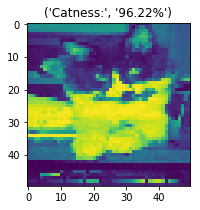

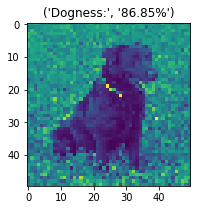

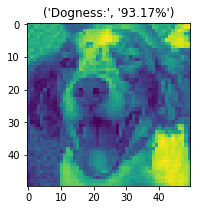

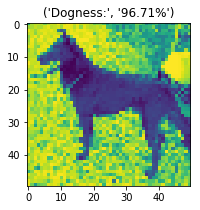

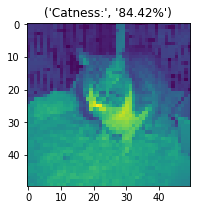

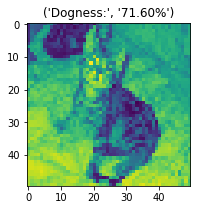

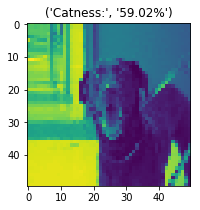

In [37]:
for i in range(18,25):
    d = test_data[i]
    img_data, img_num = d

    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict([data])[0]
    
    #print("Catness:",'%.2f'%(prediction[0]*100)+"%","   ","Dogness:",'%.2f'%(prediction[1]*100)+"%")
    
    fig = plt.figure(figsize=(3, 3))
    
    if prediction[0]> 0.5: 
        str_label= "Catness:",'%.2f'%(prediction[0]*100)+"%"
    else: 
        str_label="Dogness:",'%.2f'%(prediction[1]*100)+"%"
    
    plt.title(str_label)
    ax = fig.add_subplot(111)
    ax.imshow(img_data)#cmap="gray")